In [1]:
import math
import itertools
from collections.abc import Iterable, Collection
from numbers import Number
from typing import Tuple, List

import yaml

import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [19]:
from dataclasses import dataclass
from typing import Dict, Set, List

@dataclass
class UnionFindNode:
    """ Class for keeping Union Find Node data"""
    value: int # Value of node
    parent: int # Parent node value
    rank: int # Higher bound on height

class UnionFind:
    def __init__(self):
        
        self.nodes : Dict[int, UnionFindNode] = {}
        self.roots : Set[int] = set()
        
    def make_set(self, x: int) -> None:
        if x not in self.nodes:
            self.nodes[x] = UnionFindNode(x, x, 0)
            self.roots.add(x)
        
    def find(self, x: int) -> int:
        """ Return root of set x belongs to. None if x does not exist in any set 
        
        Parameter
        ---------
        x: int
            id of node to get root of

        Return
        -------
        root: int
            id of root of set containing node id x
        
        """
        # Check if x exist in any set
        if x not in self.nodes:
            raise ValueError(f'Key {x} not found')
        
        # Search for root and path compression
        cur_node = self.nodes[x]
        while cur_node.parent != cur_node.value:
            parent_node = self.nodes[cur_node.parent]
            cur_node.parent = self.nodes[parent_node.parent].value # update to grand parent
            cur_node = parent_node
            
        return cur_node.value
        
    def union(self, x: int, y: int) -> None:
        a = self.nodes[self.find(x)]
        b = self.nodes[self.find(y)]
        
        if a.value != b.value:
            # Union if x and y is not part of same set
            if a.rank < b.rank:
                a,b = b,a # Swap to make a at least as large as b
                x,y = y,x

            b.parent = a.value # Re-parent
            
            # b is not root anymore
            # print(f'[Union {x},{y}] {a.value=} {b.value=} Set before: {self.roots}')
            self.roots.remove(b.value)
            # self.roots.remove(y)
            # print(f'[Union {x},{y}] {a.value=} {b.value=} Set After: {self.roots}')

            if a.rank == b.rank:
                a.rank += 1 # Re calculate rank
        
    def get_roots(self) -> Set[int]:
        return self.roots
    

In [20]:
data_file = 'data/laser_scan_1.yml'

In [21]:
with open(data_file, 'r') as f:
    scan_data = yaml.safe_load(f)

In [22]:
def point_cloud_to_np(scan_record):
    scan_points = np.array([ [point['x'], point['y']] for point in scan_record['points']] )
    scan_intensities = np.array([ channel['values'][0] for channel in scan_record['channels']])

    return scan_points, scan_intensities

In [23]:
scan_points, scan_intensities = point_cloud_to_np(scan_data)

In [24]:
print(f'{scan_points.shape=}, {scan_intensities.shape=}')

scan_points.shape=(234, 2), scan_intensities.shape=(234,)


In [25]:
def format_axes(ax: matplotlib.axes.Axes, suffix='', x_bounds = None, y_bounds = None):

    # Axis Labels
    if len(suffix.strip()) != 0:
        suffix = ' ' + suffix
    
    ax.set_xlabel(f'x{suffix}')
    ax.set_ylabel(f'y{suffix}')

    # Axis bounds
    ax.axis('equal')

    if x_bounds is not None:
        ax.set_xlim(*x_bounds)

    if y_bounds is not None:
        ax.set_ylim(*y_bounds)

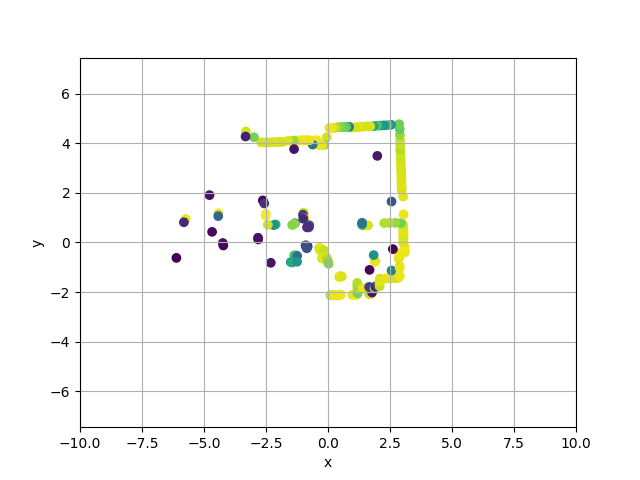

In [26]:
fig1 = plt.figure()
ax1 = fig1.gca()

ax1.scatter(scan_points[:,0], scan_points[:,1], c=scan_intensities)
ax1.grid()

format_axes(ax1, x_bounds=[-10, 10], y_bounds=[-10, 10])

In [35]:
def fit_line(points: np.ndarray) -> np.ndarray:
    """Fit line to points. Require Length at least 2 distint points.
    
    Parameters
    ---------
    points: float np.ndarray[N,2]
        points to fit the line. Require at least 2 distinct points

    Returns
    --------
    slope_intercept: float np.ndarray[2, ]
        where slope_intercept = [a b] where y = ax + b

    Raise
    -------
    ValueError
        Not enough distinct points (<2) or singular A.T @ A
    
    """
    EPSILON = 1e-5

    n = len(points)
    if n < 2:
        raise ValueError(f'Required at least 2 points. Received {n} points. {points}')

    A = np.stack([points[:, 0], np.ones((n,))], axis=-1)

    ata = A.T @ A

    det = np.linalg.det(ata)
    if np.abs(det) < EPSILON:
        raise ValueError(f'Singular. Received {n} points. {points}')
    
    ata_inverse = np.linalg.inv(ata)

    # slope_intercept = [a b].T where y=ax+b
    slope_intercept = ata_inverse @ A.T @ np.expand_dims(points[:, 1], -1)

    return np.squeeze(slope_intercept)

def slope_intercept_to_vector_form(slope_intercept: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Convert line slope intercept form to vector form
    
    Parameters
    ----------
    slope_intercept: float np.ndarray[2, ]
        [slope, intercept]

    Returns
    -------
        p: float np.ndarray[1, 2]
            position vector of point on line, orthogonal to direction
        v_hat: float np.ndarray[1, 2]
            normalized direction vector of line
    """

    # y = ax + b

    slope, intercept = slope_intercept

    v = np.array([[1.0, slope]])
    v_hat = v / np.expand_dims(np.linalg.norm(v), axis=-1)

    x = 0.0
    y = slope * x + intercept
    point_on_line = np.array([[x, y]])
    
    perpendicular_point = point_on_line - (np.sum(np.multiply(v_hat, point_on_line)))*v_hat

    return perpendicular_point, v_hat

def line_vector_form_from_line_segment(x_0: np.ndarray, x_1: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return line in vectorm form
    
    Parameters
    ----------
    x_0: float np.ndarray[1,2]
    x_1: float np.ndarray[1,2]
    
    """

    EPSILON = 1e-6

    v = x_1 - x_0
    v_norm = np.linalg.norm(v)

    if v_norm < EPSILON:
        # Same point
        raise ValueError(f'Two points are the same/. {x_0=} {x_1=}')
    
    v_hat = v / v_norm
    
    perpendicular_point = x_0 - (np.sum(np.multiply(v_hat, x_0)))*v_hat
    
    return perpendicular_point, v_hat

def line_vector_to_hessian_form(p, v_hat):
    """Assuming p is already perpendicular point"""

    r = np.linalg.norm(p)
    alpha = np.atan2(p[0,1], p[0,0])

    return np.array([r, alpha])


def get_point_line_parallel_perpendicular(points: np.ndarray, p: np.ndarray, v_hat: np.ndarray) -> np.ndarray:
    """Get point parallel distance from p and (perpendicular) distance from line defined by position p and direction v_hat
    
    Parameters
    -----------
        points: float np.ndarray[N, 2]
            points to contain in line

        p: float np.ndarray[1, 2]
            position vector of point on line, orthogonal to direction

        v_hat: float np.ndarray[1, 2]
            normalized direction vector of line

    Returns
    -----------
        points_parallel_distance: float np.ndarray[N, ]
            Parallel distance of points to p

        points_perpendicular_distance: float np.ndarray[N, ]
            Perpendicular distance of points to line
    
    """

    line_to_points = points - p
    
    points_parallel_distance = np.sum(np.multiply(line_to_points, v_hat), axis=-1)

    line_to_point_project_normal = line_to_points - np.multiply(np.expand_dims(points_parallel_distance, -1), v_hat)

    points_perpendicular_distance = np.linalg.norm(line_to_point_project_normal, axis=-1)

    return points_parallel_distance, points_perpendicular_distance

def split_and_merge_points(scan_points: np.ndarray, inlier_distance_threshold: Number, merge_distance_threshold: Number, min_line_points: int = 10) -> List[np.ndarray]:
    """Split and merge algorithm
    
    1) Fit line to set
    2) 
    
    """

    def split(scan_points: np.ndarray, inlier_distance_threshold: Number) -> List[Tuple[np.ndarray, np.ndarray]]:
        """Split subroutine.
        
        
        Returns
        --------
            lines: List[Tuple[float np.ndarray[2, ], np.ndarray[M, 2]]]
                list of tuple containing (line parameter, line points)

                line parameter: float np.ndarray[2, ]
                    Contains R, perpendicular distance from origin, and alpha, angle of normal of line to x axis

                line points: float np.ndarray[M, 2]
                    Points used to form the line
        
        """
        
        n = len(scan_points)
        if n < min_line_points:
            return []

        slope_intercept = fit_line(scan_points)
        p1, v_hat1 = slope_intercept_to_vector_form(slope_intercept)

        points_parallel_distance_1, points_perpendicular_distance_1 = get_point_line_parallel_perpendicular(scan_points, p1, v_hat1)

        furthest_distance_index = np.argmax(points_perpendicular_distance_1)
        furthest_distance = points_perpendicular_distance_1[furthest_distance_index]

        if furthest_distance < inlier_distance_threshold:
            # Return line
            return [(p1, v_hat1, scan_points)]

        # Sort points
        point_sort_index = np.argsort(points_parallel_distance_1)
        scan_points_sorted = scan_points[point_sort_index]

        # Assume sorted points
        # Points can be sorted by arranging in order of increasing parallel distance
        first_point = np.expand_dims(scan_points_sorted[0], axis=0)
        last_point = np.expand_dims(scan_points_sorted[-1], axis=0)

        p2, v_hat2 = line_vector_form_from_line_segment(first_point, last_point)

        points_parallel_distance_2, points_perpendicular_distance_2 = get_point_line_parallel_perpendicular(scan_points_sorted, p2, v_hat2)

        furthest_distance_2_index = np.argmax(points_perpendicular_distance_2)

        lines = []

        try:
            first_split = split(scan_points_sorted[:furthest_distance_2_index], inlier_distance_threshold)
            lines.extend(first_split)
        except ValueError as e:
            pass
        
        try:
            second_split = split(scan_points_sorted[furthest_distance_2_index:], inlier_distance_threshold)
            lines.extend(second_split)
        except ValueError as e:
            pass

        return lines

    def merge(line_list, merge_distance_threshold: Number, inlier_distance_threshold: Number):
        """
        
        merge_distance_threshold: Number
            threshold to consider 2 line similar

        inlier_distance_threshold: Number
            threshold to consider for line segment forming
        """


        n = len(line_list)
        print(n)

        # N x 2
        lines_hessian = np.stack([line_vector_to_hessian_form(p, v_hat) for p,v_hat,_ in line_list], axis=0)

        # Symmetric
        line_hessian_difference = np.expand_dims(lines_hessian, axis=1) - np.expand_dims(lines_hessian, axis=0)
        line_hessian_difference_2 = np.power(line_hessian_difference, 2)

        similar_line_matrix = np.sum(line_hessian_difference_2,axis=-1) <= merge_distance_threshold

        print(similar_line_matrix)


        # Form N sets
        disjoint_sets = UnionFind()
        for i in range(n):
            disjoint_sets.make_set(i)

        for i in range(n):
            for j in range(n):
                if(j >= i):
                    # Skip half triangle
                    break

                # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=}')
                if similar_line_matrix[j,i]:
                    # Combine sets
                    # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=} Pass')
                    disjoint_sets.union(i,j)

        set_roots = disjoint_sets.get_roots()

        print(set_roots)

        lines = []
        for root in set_roots:

            point_set = []
            set_size = 0
            for i in range(n):
                if similar_line_matrix[root][i]:
                    point_set.append(line_list[i][-1])
                    set_size += 1

            point_set = np.concatenate(point_set, axis=0)

            print(f'{root=} {set_size}')

            p, v_hat = line_list[root][:-1]

            if set_size > 1:
                # Fit line to point set
                line_slope_intercept = fit_line(point_set)
                p, v_hat = slope_intercept_to_vector_form(line_slope_intercept)
            line_segment = line_to_segment(point_set, p, v_hat, inlier_distance_threshold)

            lines.append((line_segment, point_set))

        return lines
    
    line_list = split(scan_points, inlier_distance_threshold)
    
    refined_line_list = merge(line_list, merge_distance_threshold, inlier_distance_threshold)

    return refined_line_list

def line_to_segment(points: np.ndarray, p: np.ndarray, v_hat: np.ndarray, inlier_distance_threshold: Number):
    """Convert line to line segments given points and slope_intercept parameters. Convert to (x1, y1) , (x2, y2)

    Parameters
    ---------
    points: float np.ndarray[N, 2]
        points to contain in line

    p: float np.ndarray[1, 2]
            position vector of point on line, orthogonal to direction

    v_hat: float np.ndarray[1, 2]
        normalized direction vector of line

    inlier_distance_threshold: Number
        shortest distance to line to consider inliers

    Returns
    --------
    bounds: float np.ndarray[2, 2]
        bounds array. bounds = [[x1, y1], [x2, y2]]

    """

    # Len of points must be at least 2
    n = len(points)
    
    if n < 2:
        raise ValueError(f'Required at least 2 points. Received {n} points. {points}')

    points_parallel_distance, points_perpendicular_distance = get_point_line_parallel_perpendicular(points, p, v_hat)

    inlier_masks = points_perpendicular_distance < inlier_distance_threshold

    inlier_line_project_magnitude = points_parallel_distance[inlier_masks]

    sorted_points_index = np.argsort(inlier_line_project_magnitude)

    first_point_magnitude = inlier_line_project_magnitude[sorted_points_index[0]]
    last_point_magnitude = inlier_line_project_magnitude[sorted_points_index[-1]]

    first_line_end = p + first_point_magnitude * v_hat
    last_line_end = p + last_point_magnitude * v_hat

    return np.concatenate([first_line_end, last_line_end], axis=0)

In [36]:
disjoint_sets = UnionFind()

In [37]:
for i in range(5):
    disjoint_sets.make_set(i)

In [38]:
disjoint_sets.roots

{0, 1, 2, 3, 4}

In [39]:
disjoint_sets.nodes

{0: UnionFindNode(value=0, parent=0, rank=0),
 1: UnionFindNode(value=1, parent=1, rank=0),
 2: UnionFindNode(value=2, parent=2, rank=0),
 3: UnionFindNode(value=3, parent=3, rank=0),
 4: UnionFindNode(value=4, parent=4, rank=0)}

In [40]:
disjoint_sets.union(1,2)

[Union 1,2] a.value=1 b.value=2 Set before: {0, 1, 2, 3, 4}
[Union 1,2] a.value=1 b.value=2 Set After: {0, 1, 3, 4}


In [41]:
line_list = split_and_merge_points(scan_points, 0.1, 0.5)

7
[[ True False False  True False False False]
 [False  True  True False False False False]
 [False  True  True False False False False]
 [ True False False  True False False False]
 [False False False False  True False False]
 [False False False False False  True  True]
 [False False False False False  True  True]]
[Union 2,1] a.value=2 b.value=1 Set before: {0, 1, 2, 3, 4, 5, 6}
[Union 2,1] a.value=2 b.value=1 Set After: {0, 2, 3, 4, 5, 6}
[Union 3,0] a.value=3 b.value=0 Set before: {0, 2, 3, 4, 5, 6}
[Union 3,0] a.value=3 b.value=0 Set After: {2, 3, 4, 5, 6}
[Union 6,5] a.value=6 b.value=5 Set before: {2, 3, 4, 5, 6}
[Union 6,5] a.value=6 b.value=5 Set After: {2, 3, 4, 6}
{2, 3, 4, 6}
root=2 2
root=3 2
root=4 1
root=6 2


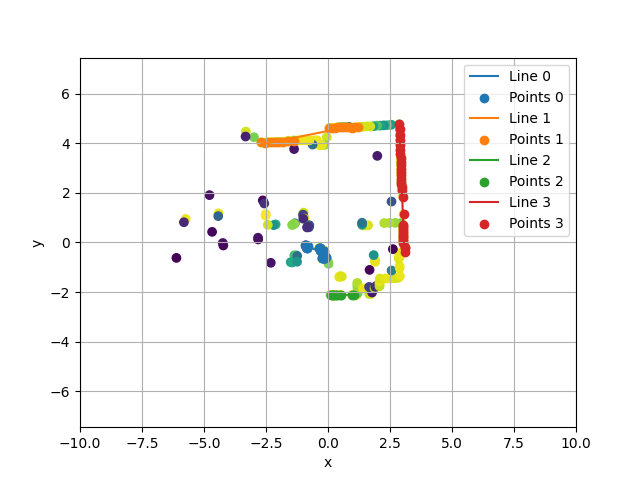

In [43]:
fig2 = plt.figure()
ax2 = fig2.gca()

# Plot Points
ax2.scatter(scan_points[:,0], scan_points[:,1], c=scan_intensities)

# Plot lines
for i, (end_points, point_set) in enumerate(line_list):
    ax2.plot(
        end_points[:, 0],
        end_points[:, 1],
        label=f'Line {i}'
    )

    ax2.scatter(point_set[:,0], point_set[:,1],label=f'Points {i}')

ax2.grid()
ax2.legend()

format_axes(ax2, x_bounds=[-10, 10], y_bounds=[-10, 10])

## Subset

In [45]:
scan_points_subset_mask = scan_points[:, 1] > 3
scan_points_subset = scan_points[scan_points_subset_mask]
scan_intensities_subset = scan_intensities[scan_points_subset_mask]

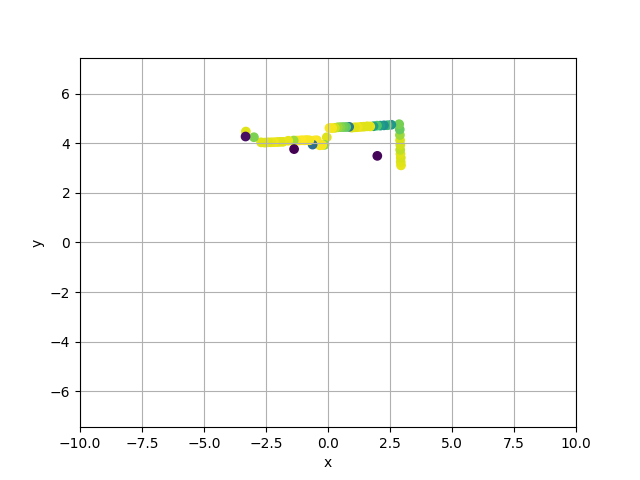

In [73]:
fig3 = plt.figure()
ax3 = fig3.gca()

# Plot Points
ax3.scatter(scan_points_subset[:,0], scan_points_subset[:,1], c=scan_intensities_subset)

# Plot lines
# for end_points, _ in line_list:
#     ax3.plot(
#         end_points[:, 0],
#         end_points[:, 1]
#     )

ax3.grid()

format_axes(ax3, x_bounds=[-10, 10], y_bounds=[-10, 10])

In [104]:
line_list = []


line_list.extend(split_and_merge_points(scan_points_subset, 0.2, 0.0))

4
[[ True False False False]
 [False  True False False]
 [False False  True False]
 [False False False  True]]
{0, 1, 2, 3}
root=0 1
root=1 1
root=2 1
root=3 1


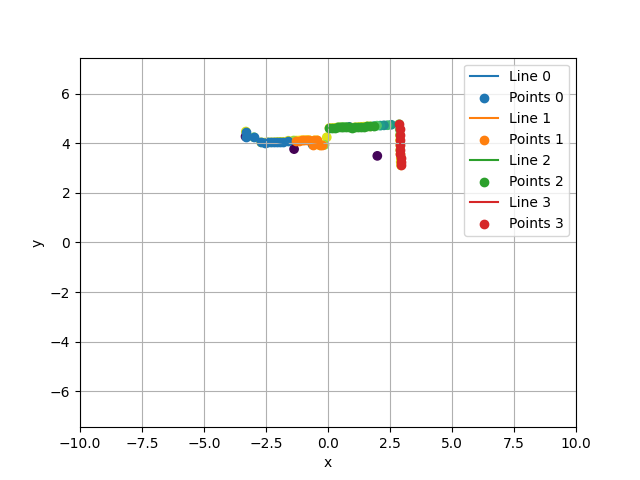

In [105]:
fig4 = plt.figure()
ax4= fig4.gca()

# Plot Points
ax4.scatter(scan_points_subset[:,0], scan_points_subset[:,1], c=scan_intensities_subset)

# Plot lines
for i, (end_points, point_set) in enumerate(line_list):
    ax4.plot(
        end_points[:, 0],
        end_points[:, 1],
        label=f'Line {i}'
    )

    ax4.scatter(point_set[:,0], point_set[:,1],label=f'Points {i}')

ax4.grid()
ax4.legend()

format_axes(ax4, x_bounds=[-10, 10], y_bounds=[-10, 10])

In [16]:
multi_data_file = 'data/laser_scan_set_1.yml'

In [15]:
with open(multi_data_file, 'r') as f:
    scan_records = yaml.safe_load(f)

In [16]:
print(f'Record: {len(scan_records)}')

Record: 26


In [17]:
scan_data_multi = []
for record in scan_records:
    scan_data_multi.append(point_cloud_to_np(record))

In [25]:
accumulate_window_size = 5
window_offset = 0

In [26]:
scan_points_multi, scan_intensities_multi = list(zip(*scan_data_multi[window_offset:window_offset + accumulate_window_size]))
scan_points_multi = np.concatenate(scan_points_multi, axis=0)
scan_intensities_multi = np.concatenate(scan_intensities_multi, axis=0)

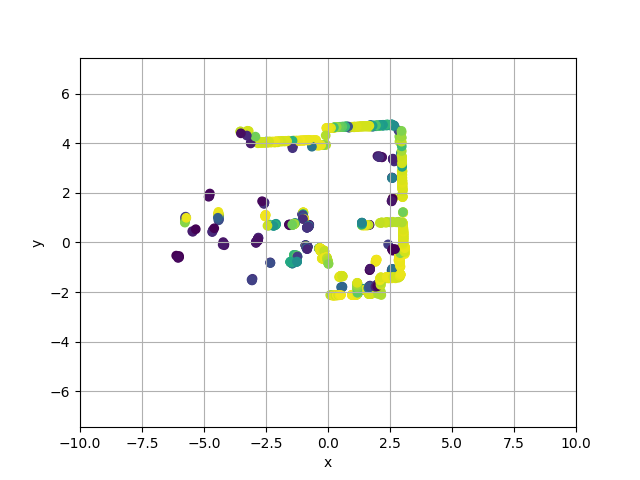

In [31]:
fig3 = plt.figure()
ax3 = fig3.gca()

# Plot Points
ax3.scatter(scan_points_multi[:,0], scan_points_multi[:,1], c=scan_intensities_multi)

# Plot lines
# for end_points, _ in line_list:
#     ax3.plot(
#         end_points[:, 0],
#         end_points[:, 1]
#     )

ax3.grid()

format_axes(ax3, x_bounds=[-10, 10], y_bounds=[-10, 10])

In [44]:
line_list = split_and_merge_points(scan_points_multi, 0.05, 0.01, min_line_points=5)

70
(70, 2)
(70, 70, 2)
(70, 70)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
root=0 1 [[-6.00708199 -0.54771465]
 [-5.76998138  0.79871023]
 [-5.77294827  0.82074845]
 [-5.75896597  0.8746047 ]
 [-5.75836849  0.89820677]
 [-5.75500727  0.93832278]
 [-5.74560261  0.95847321]
 [-5.76274109  1.01819587]]
root=1 1 [[-4.78262186  1.92100036]
 [-4.78964663  1.90341723]
 [-4.78337669  1.86749482]
 [-4.81404209  1.84084558]
 [-4.41892958  1.23029661]
 [-4.41840219  1.18287694]
 [-4.42271805  1.16663671]
 [-4.43603563  1.13929164]
 [-4.43999958  1.10733092]]
root=2 1 [[-4.38725328  1.10798681]
 [-4.42615414  1.07148254]
 [-4.43881607  1.05729902]
 [-4.40186214  1.01780891]
 [-4.43911028  0.99383014]
 [-4.39593267  0.95277649]
 [-4.40166235  0.90631348]
 [-4.41801262  0.891

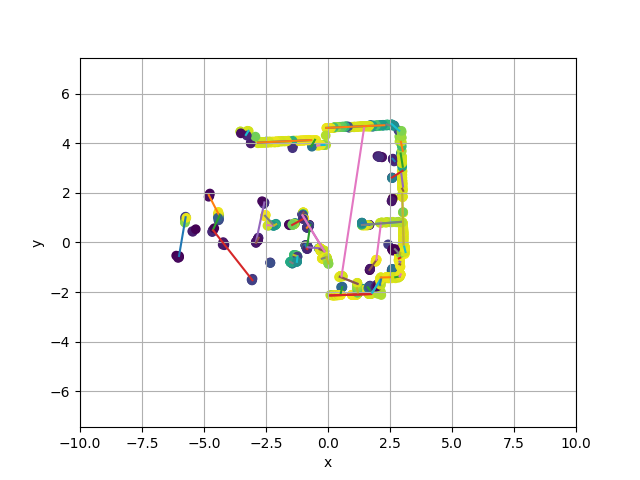

In [45]:
fig4 = plt.figure()
ax4 = fig4.gca()

# Plot Points
ax4.scatter(scan_points_multi[:,0], scan_points_multi[:,1], c=scan_intensities_multi)

# Plot lines
for end_points, _ in line_list:
    ax4.plot(
        end_points[:, 0],
        end_points[:, 1]
    )

ax4.grid()

format_axes(ax4, x_bounds=[-10, 10], y_bounds=[-10, 10])